In this code we will introduce 3 individual recommenders and evaluate them.Implemented recommenders are: content based rs, user based cf, item based cf. After implementing them we will compare these three individual recommenders with out baselines. As the main baseline we will compare fallback because we already saw that it performs better than other two.


Firstly we import our preprocessed dataset. Bellow you can see how ratinggs_df looks like.

In [1]:
import pandas as pd
preprocessed_dataset_folder = "../Data/PreprocessedDataset"
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv")
movies_df = pd.read_csv(preprocessed_dataset_folder+"/movies.csv")
display(ratings_df.head(10))

,user,item,rating,timestamp
0,17783,5954,5.0,1288572640
1,147353,2805,2.0,979368264
2,32778,1982,4.0,1559214270
3,17160,1225,4.5,1151466878
4,58005,6537,3.0,1112739432
5,133040,736,2.0,1076959711
6,73670,4975,2.0,1415292692
7,118041,1248,4.5,1522631138
8,73268,122904,0.5,1475355740
9,133495,1388,1.0,991281570


Bellow you can see how our movies dataframe looks like.

In [2]:
display(movies_df.head(5))

,item,title_original,genres,year,title,cast,director,origin,plot
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,toy story,"tim allen, tom hanks (voices)",john lasseter,american,In a world where toys are living things who pr...
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,jumanji,"robin williams, bonnie hunt, kirsten dunst, br...",joe johnston,american,"In 1869, near Brantford, New Hampshire, two br..."
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,grumpier old men,"jack lemmon, walter matthau, ann-margret, soph...",howard deutch,american,The feud between Max (Walter Matthau) and John...
3,5,Father of the Bride Part II (1995),Comedy,1995,father of the bride part ii,"steve martin, diane keaton, martin short, kimb...",charles shyer,american,The film begins five years after the events of...
4,6,Heat (1995),Action|Crime|Thriller,1995,heat,"al pacino, robert de niro, val kilmer, ashley ...",michael mann,american,"Neil McCauley, a career criminal, hires Waingr..."


# Movie dataframe preprocessing for content based/matrix factorisation

For content based recommendations we decided to use plots to which title and genres of movies are appended. As preprocessing before applying k-nearest neighbours algorithm we will firstly tokenize plot, remove stopwords (just english ones) and then we will put all to lower case.

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np

def preprocess_plot_text(plot_text):
    tokens = word_tokenize(plot_text.replace("|"," ")) # to split genres
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    return " ".join(filtered_tokens)

movies_df['plot + title + genres'] = (movies_df['plot']+" "+movies_df['title']+" "+movies_df['genres']).apply(preprocess_plot_text)

Next we will for each user get plots+title+genres of movies they rated. We won't consider unrated movies because we want to evaluate recommender and have a ground truth for it. So we filter out unrated movies.

In [4]:
def get_user_rated_movies_plots(user):
    selected_user_ratings = ratings_df[ratings_df['user'] == user]
    rated_item_ids = list(selected_user_ratings['item'])
    rated_movies_df = movies_df[movies_df['item'].isin(rated_item_ids)]
    rated_movies_df = rated_movies_df[['item','plot + title + genres']]
    selected_user_ratings = selected_user_ratings.set_index('item') 
    rated_movies_df = rated_movies_df.join(selected_user_ratings['rating'], on='item')
    rated_movies_df['user_id'] = user
    return rated_movies_df

In the next code cell for simplicity we evaluate our content based collaborative filltering based on holdout method where we take train test split equal 80%-20%.
For metrics we decided to use MAE and RMSE to evaluate all of the predictions, and we decided to use nDCG to evaluate recommendation of 10 items to each user.
Reason why we picked MAE is that it is the easiest to interpret its values (when MAE is for example 0.7 then we know that our recommendation is wrong on average for 0.7 rating). Next to MAE we also used RMSE because it penalizes more outliers in porediction and we want all users to get similary satisfied and not to have too much off calculations. We also wanted to evaluate how good our recommendations are when we predict list of top 10 items and that is why we decided to use nDCG. We picked nDCG because it is most used metrics for ranks in recommended systems and we could find nice built in application of rank_score metrics.


In [5]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import ndcg_score

rmse_scores = []
mae = []
ndcg = []
predictions_all = []
user_list = list(set(ratings_df['user']))
user_plots_list = pd.DataFrame()
for user in user_list:
    user_plots_ratings_df = get_user_rated_movies_plots(user)
    user_plots_list = pd.concat([user_plots_list,user_plots_ratings_df])
    X = user_plots_ratings_df['plot + title + genres']
    y = user_plots_ratings_df['rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    neigh = KNeighborsRegressor(n_neighbors=12, metric='cosine') # we choose cosine metric because we are using tfidf vectors and it gives better similarity measure
                                                                # we choose n_neighbors=12 because there exists user with just 12 neighbors which we didnt filter out
    neigh.fit(X_train_tfidf, y_train) 
    y_pred = neigh.predict(X_test_tfidf)
    recommendations_df = pd.DataFrame({
        'user': user,
        'predicted_rating': y_pred,
        'actual_rating': y_test.values
    })
    min_score = recommendations_df['predicted_rating'].min()
    max_score = recommendations_df['predicted_rating'].max()
    recommendations_df['predicted_rating'] = 5 * (recommendations_df['predicted_rating'] - min_score) / (max_score - min_score)
    predictions_all.append(recommendations_df)
    recommendations_df = recommendations_df.sort_values(by=['predicted_rating'], ascending=False).head(10)
    knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    knn_mae = mean_absolute_error(y_test, y_pred)
    knn_ndcg = ndcg_score([recommendations_df['actual_rating'].apply(lambda x: 1 if x>2.5 else 0)], [recommendations_df['predicted_rating'].apply(lambda x: 1 if x>2.5 else 0)])
    rmse_scores.append(knn_rmse)
    mae.append(knn_mae)
    ndcg.append(knn_ndcg)
user_plots_folder = "..\\data\\PreprocessedDataset"
user_plots_list.to_csv(user_plots_folder+"\\user_plots.csv", index=False)
    
    

Bellow you can see results for each of above described metrics. Later we will cmake comparison with other recommenders to see which one performs the best on MovieLens dataset.

In [6]:
print("KNN RMSE: ", np.mean(rmse_scores))
print("KNN MAE: ", np.mean(mae))
print("KNN NDCG: ", np.mean(ndcg))

KNN RMSE:  0.8862657657341024
KNN MAE:  0.7167635887952459
KNN NDCG:  0.908630391613485


Bellow you can see top 10 recommendations of our content based recommender to an user with predicted and their actual rating.

In [7]:
print(predictions_all[0].sort_values(by=['predicted_rating'], ascending=False).head(10))

     user  predicted_rating  actual_rating
10  71683            5.0000            3.0
11  71683            3.7500            1.0
1   71683            3.4375            3.5
2   71683            2.8125            5.0
3   71683            2.8125            3.5
4   71683            2.8125            3.0
12  71683            2.8125            4.0
0   71683            2.5000            3.0
13  71683            2.5000            5.0
6   71683            2.1875            3.0


# Collaborative filtering (KNN)
Next we will create a collaborative filltering recommender system. We decided to implement both item based and user based on compare them. We want to prove hypothesis which professor mentioned in the class, there is no significant difference in results considering user based and item based cf. To do that comparison we will use also additional metrics such as precision recall and f1 score. To compare collaborative filltering with other implemented algorithms we will also use RMSE,MAE and nDCG.

In [8]:
from lenskit.metrics.predict import rmse
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser # collaborative filtering
from lenskit.algorithms.item_knn import ItemItem # collaborative filtering
from lenskit.algorithms.mf_common import MFPredictor

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt


train_dataframe, test_dataframe = train_test_split(ratings_df, test_size=0.2, random_state=42) # 80-20 train test split

user_user = UserUser(15, min_nbrs=12)
item_item = ItemItem(15, min_nbrs=12)

def evaluate_collaborative_filtering(model, train_df, test_df):
    recsys = Recommender.adapt(model)
    recsys.fit(train_df)
    test_df['predicted_rating'] = recsys.predict(test_df)
    min_score = test_df['predicted_rating'].min()
    max_score = test_df['predicted_rating'].max()
    test_df['predicted_rating'] = 5 * (test_df['predicted_rating'] - min_score) / (max_score - min_score)
    test_df['relevant'] = test_df['rating'].apply(lambda x: 1 if x>2.5 else 0)
    test_df['predicted_relevant'] = test_df['predicted_rating'].apply(lambda x: 1 if x>2.5 else 0)
    y_test = list(test_df['relevant'])
    y_pred = list(test_df['predicted_relevant'])
    recommendations_df = pd.DataFrame({
        'user': user,
        'predicted_rating': test_df['predicted_rating'],
        'actual_rating': test_df['rating']
    })
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

    print("Precision:\t" + str(precision) +
          "\nRecall:\t" + str(recall) +
          "\nFscore:\t" + str(fscore))
    return precision, recall, fscore, recommendations_df


In code bellow we run evaluation of collaborative filltering for both item based and user based. Also for this evaluation we decided to use holdout method with 80-20 split because it is easier to implement.

In [9]:
precision_user, recall_user, fscore_user,predictions_cf_user = evaluate_collaborative_filtering(user_user, train_dataframe, test_dataframe)
precision_item, recall_item, fscore_item,predictions_cf_item = evaluate_collaborative_filtering(item_item, train_dataframe, test_dataframe)

Numba is using threading layer omp - consider TBB
found 1 potential runtime problems - see https://boi.st/lkpy-perf


Precision:	0.8729345830515025
Recall:	0.8423310023310023
Fscore:	0.8573597798234792
Precision:	0.888723245660739
Recall:	0.7781818181818182
Fscore:	0.8297872340425532


Bellow you can see top 10 recommendations to an user made by user based collaborative filtering

In [10]:
print(predictions_cf_user.sort_values(by=['predicted_rating'], ascending=False).head(10))

         user  predicted_rating  actual_rating
2891   126970          5.000000            5.0
2826   126970          4.797325            4.5
10595  126970          4.789462            5.0
3867   126970          4.754614            5.0
27227  126970          4.707020            5.0
60578  126970          4.701433            5.0
6467   126970          4.689888            4.5
62998  126970          4.664136            5.0
68401  126970          4.645482            5.0
51892  126970          4.639464            5.0


Bellow you can see top 10 recommendations to an user made by item based collaborative filtering

In [11]:
print(predictions_cf_item.sort_values(by=['predicted_rating'], ascending=False).head(10))


         user  predicted_rating  actual_rating
62998  126970          5.000000            5.0
9767   126970          4.803346            5.0
30923  126970          4.795399            5.0
27227  126970          4.753952            5.0
50766  126970          4.717074            5.0
9473   126970          4.621910            5.0
64856  126970          4.613602            5.0
66773  126970          4.566807            5.0
4879   126970          4.544991            4.0
2891   126970          4.487561            5.0


Bellow we plot the values for precision, recall and Fscore for user-based(UU) and item-based (II). We can conclude our hypothesis that in all of these metrics user based and item based collaborative filltering perform with no significant difference. In all metrics value of difference is less than 0.01. 

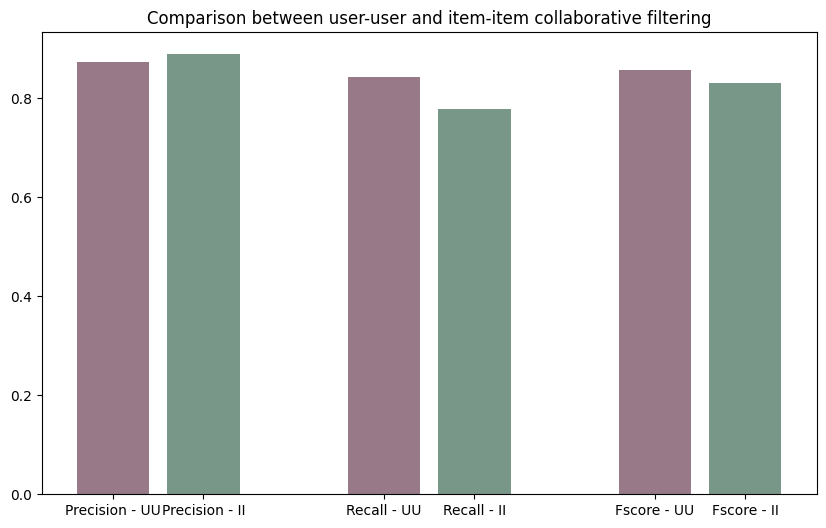

In [12]:
plt.figure(figsize=(10,6))
plt.bar(x = [0, 1 , 3, 4, 6, 7], height = [precision_user, precision_item, recall_user, recall_item, fscore_user, fscore_item], tick_label= ['Precision - UU', 'Precision - II', 'Recall - UU', 'Recall - II', 'Fscore - UU', 'Fscore - II'], color= ["#987987","#789789","#987987","#789789","#987987","#789789"])
plt.title('Comparison between user-user and item-item collaborative filtering')
plt.show()

Next for the sake of comparison with other implemented algorithms we made 7-fold evaluation of collaborative filltering so we can sompare the results with content based and fallback recommender (shown to be best one among baseline recommenders).

In [13]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lenskit.metrics import topn
from lenskit import batch
from sklearn.model_selection import KFold

def evaluate_collaborative_filtering_kfold(model, K):
    kf = KFold(n_splits=K, shuffle=True, random_state=42)

    rmse_list = list()
    mae_list = list()
    ndcg_list = list()

    for train_index, test_index in kf.split(ratings_df):
        train_df = ratings_df.iloc[train_index].copy()
        test_df = ratings_df.iloc[test_index].copy()
        recsys = Recommender.adapt(model)
        recsys.fit(train_df)
        test_df['score'] = recsys.predict(test_df)
        min_score = test_df['score'].min()
        max_score = test_df['score'].max()
        test_df['score'] = 5 * (test_df['score'] - min_score) / (max_score - min_score)
        test_df = test_df.dropna(subset=['score'])
        rmse = np.sqrt(mean_squared_error(test_df['rating'], test_df['score']))
        mae = mean_absolute_error(test_df['rating'], test_df['score'])
        rmse_list.append(rmse)
        mae_list.append(mae)
        for user in test_df['user'].unique():
            user_predictions = test_df[test_df['user'] == user]
            if len(user_predictions) > 1:
                recommendations_df = pd.DataFrame({
                    'user': user,
                    'predicted_rating': test_df[test_df['user']==user]['score'],
                    'actual_rating': test_df[test_df['user']==user]['rating']
                })
                recommendations_df = recommendations_df.sort_values(by=['predicted_rating'], ascending=False).head(10)
                ndcg_value = ndcg_score([recommendations_df['actual_rating'].apply(lambda x: 1 if x>2.5 else 0)], [recommendations_df['predicted_rating'].apply(lambda x: 1 if x>2.5 else 0)])
                ndcg_list.append(ndcg_value)

    avg_rmse = np.mean(rmse_list)
    avg_mae = np.mean(mae_list)
    avg_ndcg = np.mean(ndcg_list)

    results = {
        'avg_rmse': avg_rmse,
        'avg_mae': avg_mae,
        'avg_ndcg': avg_ndcg
    }

    print(results)
    return results


Bellow we run 7-fold evaluation for each of collaborative filtering algorithms.

In [14]:
user_user_metrics = evaluate_collaborative_filtering_kfold(user_user, 7)
item_item_metrics = evaluate_collaborative_filtering_kfold(item_item, 7)

{'avg_rmse': 0.9195284268170018, 'avg_mae': 0.7370477537257744, 'avg_ndcg': 0.9288916013102847}
{'avg_rmse': 0.9744751830845865, 'avg_mae': 0.7949112399210722, 'avg_ndcg': 0.930994813283935}


Down we experiment between here implemented individual recommenders and Bias as the best baseline. Values we use for Bias are taken from one run and copy pastead because we cannot take values from another ipynb. 
Average RMSE over all splits for Bias algo : 0.92
Average MAE over all splits for Bias algo: 0.74
Average nDCG over all splits for Bias algo: 0.95

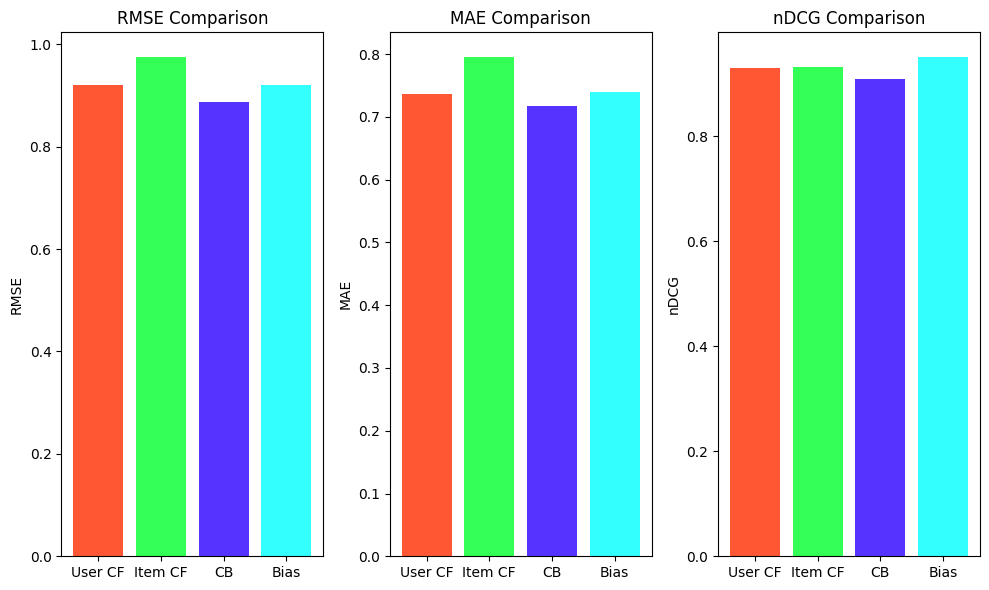

In [15]:
import matplotlib.pyplot as plt
import numpy as np

rmse_scores = [user_user_metrics['avg_rmse'], item_item_metrics['avg_rmse'], np.mean(rmse_scores), 0.92]
mae_scores = [user_user_metrics['avg_mae'], item_item_metrics['avg_mae'], np.mean(mae), 0.74]
ndcg_scores = [user_user_metrics['avg_ndcg'], item_item_metrics['avg_ndcg'], np.mean(ndcg), 0.95]

algorithms = ['User CF', 'Item CF', 'CB', 'Bias']
colors = ['#FF5733', '#33FF57', '#5733FF', '#33FFFF']

plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.bar(algorithms, rmse_scores, color=colors)
plt.ylabel('RMSE')
plt.title('RMSE Comparison')

plt.subplot(1, 3, 2)
plt.bar(algorithms, mae_scores, color=colors)
plt.ylabel('MAE')
plt.title('MAE Comparison')

plt.subplot(1, 3, 3)
plt.bar(algorithms, ndcg_scores, color=colors)
plt.ylabel('nDCG')
plt.title('nDCG Comparison')

plt.tight_layout()
plt.show()


In the presented evaluation results, the user-based collaborative filtering approach excels in terms of Root Mean Square Error (RMSE). RMSE is a measure of prediction accuracy that penalizes large errors. User-based collaborative filtering likely performs well in RMSE because it captures intricate user preferences by identifying similar users and recommending items based on their collective behavior. When users exhibit similar tastes, user-based collaborative filtering can generate accurate predictions, thus minimizing RMSE. However, user-based methods can suffer from scalability issues as the user-item interaction matrix grows. Additionally, they might not handle sparse data well, potentially leading to less accurate predictions for users with limited ratings history. These limitations might not have significantly impacted RMSE in this evaluation, explaining why user-based collaborative filtering outperformed other methods in this specific metric.

On the other hand, Mean Absolute Error (MAE) provides a different perspective. It measures the average absolute difference between predicted and actual ratings, focusing on the magnitude of errors rather than their square. Content-based recommenders outperform other methods in MAE, suggesting that they excel in capturing the overall trend of user preferences. Content-based approaches leverage item features to make recommendations, making them effective when users' tastes align with specific item characteristics. This could explain their success in reducing MAE, as they focus on general trends within the data. Bias recommender's slight advantage in nDCG (Normalized Discounted Cumulative Gain) might stem from its ability to account for user and item biases, which can improve the ranking quality of recommendations. The unsignificant difference indicates that bias recommender's strengths might be more pronounced in specific scenarios or with particular subsets of users.

As results we can see that content based recommender gives the lowest error for both MAE and RMSE metrics. Best one for nDCG is Bias recommender. We can conclude that for the need of recommending top 10 items nDCG Bias recommender is the best because it shows highly relevant items before in the sequence. On the other hand recommender which make smallest error while predicting ratings for rmse is content based recommender with knn classifier. We also can see that for metrics MAE and RMSE user based cf outperforms item based cf. The way how we could improve even more our scores is that we preprocessed dataset even more and filltered out more users (make treshold on number of ratings higher). In that way we could have made for our knn classifier neighbourhood size larger and with that our error would be lower. 